# SUDOKU DETECTION

## PREPARING THE ENVIRONMENT

Importing the libraries:

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.models import load_model

## PRE-PROCESSING

Loading image for testing and digit recognition model:

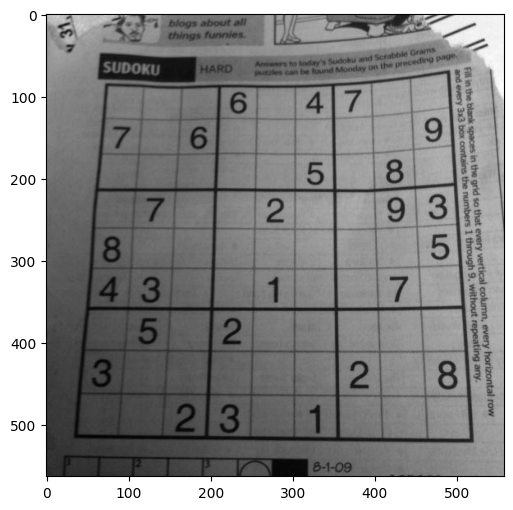

In [2]:
file_path  = '..\\examples\\sudoku_test.png'
model_path = '..\\models\\digits.keras'

image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
model = load_model(model_path)

plt.figure(figsize=(8, 6))
plt.imshow(image, cmap='gray')
plt.show()

Pre-processing the image:

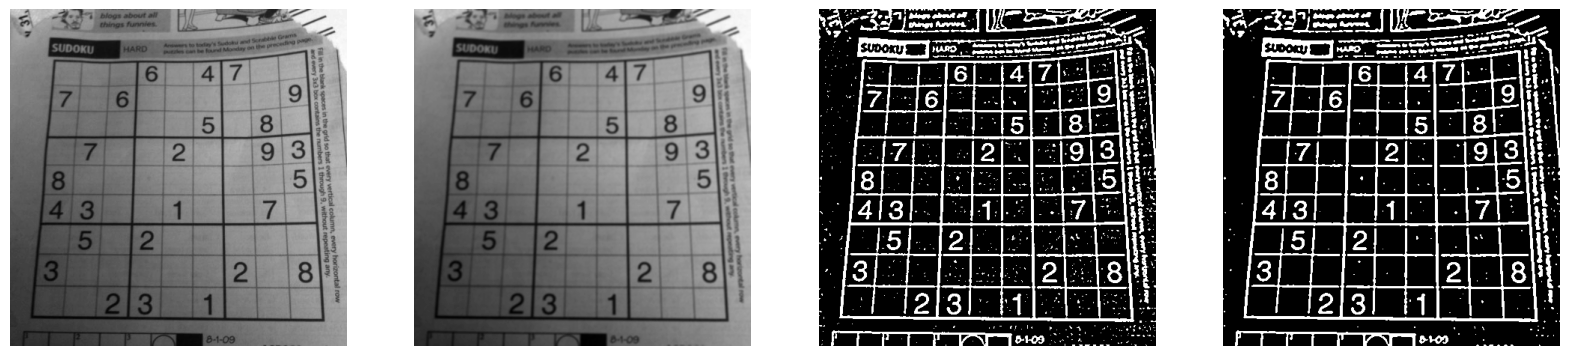

In [3]:
shape = 450, 450

image_resized    = cv2.resize(image, shape)
image_gaussian   = cv2.GaussianBlur(image_resized, (3, 3), 6)
image_threshold  = cv2.adaptiveThreshold(image_gaussian, 255, 1, 1, 11, 2)
image_median     = cv2.medianBlur(image_threshold, 3)

plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(image_resized, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(image_gaussian, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(image_threshold, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(image_median, cmap='gray')
plt.axis('off')

plt.show()

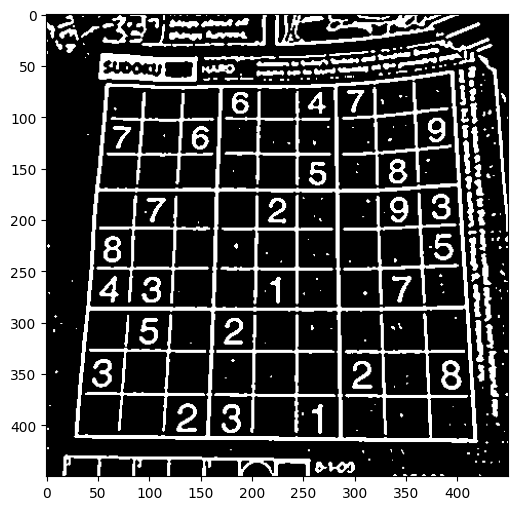

In [4]:
def preprocess(image):
    image_resized    = cv2.resize(image, shape)
    image_gaussian   = cv2.GaussianBlur(image_resized, (3, 3), 6)
    image_threshold  = cv2.adaptiveThreshold(image_gaussian, 255, 1, 1, 11, 2)
    image_median     = cv2.medianBlur(image_threshold, 3)

    return image_median

image_processed = preprocess(image)

plt.figure(figsize=(8, 6))
plt.imshow(image_processed, cmap='gray')
plt.show()

## SUDOKU_DETECTION

Detecting the image contours:

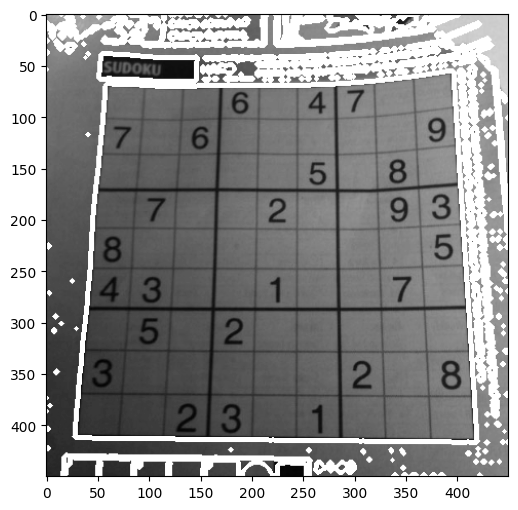

In [5]:
contours, _ = cv2.findContours(image_processed,
                               cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)

image_contour = cv2.resize(image, shape)
cv2.drawContours(image_contour, contours, -1, 255, 3)

plt.figure(figsize=(8, 6))
plt.imshow(image_contour, cmap='gray')
plt.show()

In [6]:
MIN_AREA = (shape[0] * shape[1]) / 4

def biggest_contour(contours):
    contour  = None
    max_area = 0

    for c in contours:
        area = cv2.contourArea(c)

        if area < MIN_AREA:
            continue

        perimeter    = cv2.arcLength(c, True)
        approx_curve = cv2.approxPolyDP(c, 0.02* perimeter, True)

        if area > max_area and len(approx_curve) == 4:
            contour  = approx_curve
            max_area = area

    return contour

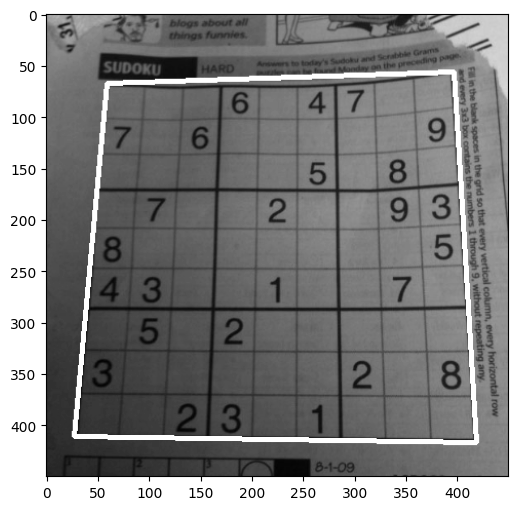

In [7]:
contour = biggest_contour(contours)

image_contour = cv2.resize(image, shape)
cv2.drawContours(image_contour, [contour], -1, 255, 3)

plt.figure(figsize=(8, 6))
plt.imshow(image_contour, cmap='gray')
plt.show()

Detecting the sudoku grid:

In [8]:
def reframe(points):
    points = points.reshape((4, 2))
    reordered_points = np.zeros((4, 1, 2), dtype=np.float32)

    point_sums = points.sum(axis=1)
    point_diff = np.diff(points, axis=1)

    reordered_points[0] = points[np.argmin(point_sums)]
    reordered_points[3] = points[np.argmax(point_sums)]
    reordered_points[1] = points[np.argmin(point_diff)]
    reordered_points[2] = points[np.argmax(point_diff)]
    
    return reordered_points

def get_perspective(image, shape, contour):
    p1 = reframe(contour)
    p2 = np.float32([[  0,   0],
                     [450,   0],
                     [  0, 450],
                     [450, 450]])
    m = cv2.getPerspectiveTransform(p1, p2)

    return cv2.warpPerspective(image, m, shape)

Testing on the original image:

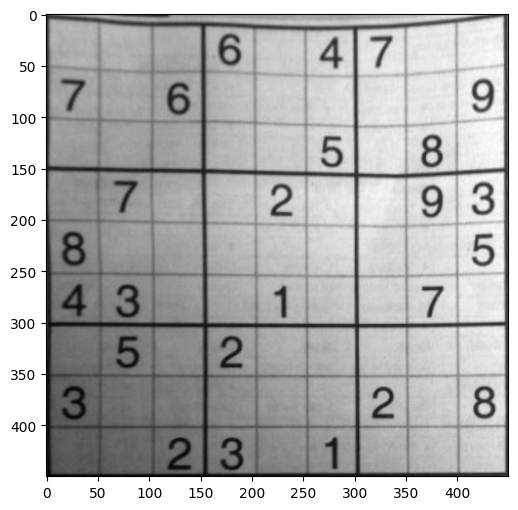

In [9]:
image_sudoku = get_perspective(cv2.resize(image, shape), shape, contour)

plt.figure(figsize=(8, 6))
plt.imshow(image_sudoku, cmap='gray')
plt.show()

Testing on pre-processed image:

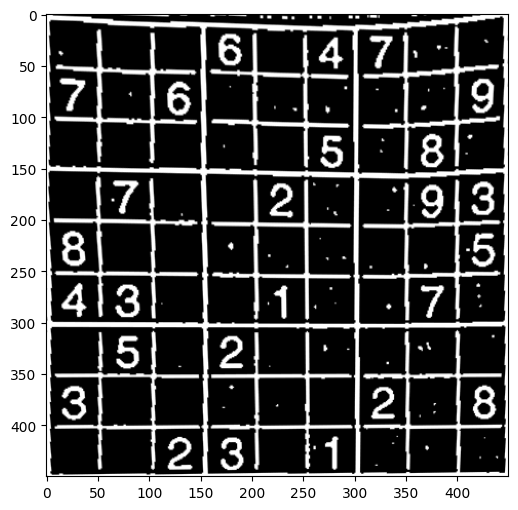

In [10]:
image_sudoku = get_perspective(image_processed, shape, contour)

plt.figure(figsize=(8, 6))
plt.imshow(image_sudoku, cmap='gray')
plt.show()

## SPLITTING CELLS AND PREDICTION

Getting each cell of the sudoku grid:

In [11]:
def get_number(cell):
    contours, _ = cv2.findContours(cell,
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return cell

    contour = max(contours, key=len)
    if len(contour) < 10:
        return cell

    x, y, w, h = cv2.boundingRect(contour)

    side_length = max(w, h)
    x_center = x + w // 2
    y_center = y + h // 2
    x_square = x_center - side_length // 2
    y_square = y_center - side_length // 2

    x_square = max(x_square, 0)
    y_square = max(y_square, 0)
    x_square_end = min(x_square + side_length, cell.shape[1])
    y_square_end = min(y_square + side_length, cell.shape[0])

    return cell[y_square : y_square_end,
                x_square : x_square_end]

def split_cells(image):
    return [cell
            for row  in np.vsplit(image, 9)
            for cell in np.hsplit(row  , 9)]

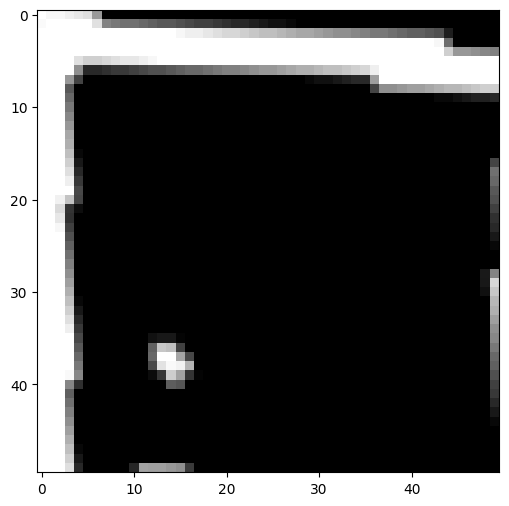

In [12]:
cells = split_cells(image_sudoku)

plt.figure(figsize=(8, 6))
plt.imshow(cells[0], cmap='gray')
plt.show()

Predicting the value of each cell:

In [13]:
shape_cell = 32, 32

grid = np.zeros(81, 'uint8')
for idx, cell in enumerate(cells):
    if np.sum(cell) < 135000:
        continue

    cell = get_number(cell[5:-5, 5:-5])
    cell = cv2.resize(cell, shape_cell)
    cell = cell / 255.

    cell = np.expand_dims(cell, axis=[0, -1])
    pred = model.predict(cell, verbose=0).squeeze()

    label = np.argmax(pred)
    if pred[label] >= 0.5:
        grid[idx] = label

grid = grid.reshape(9, 9)
grid

array([[0, 0, 0, 6, 0, 4, 7, 0, 0],
       [7, 0, 6, 0, 0, 0, 0, 0, 9],
       [0, 0, 0, 0, 0, 5, 0, 8, 0],
       [0, 7, 0, 0, 2, 0, 0, 9, 3],
       [8, 0, 0, 0, 0, 0, 0, 0, 5],
       [4, 3, 0, 0, 1, 0, 0, 7, 0],
       [0, 5, 0, 2, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0, 2, 0, 8],
       [0, 0, 2, 3, 0, 1, 0, 0, 0]], dtype=uint8)

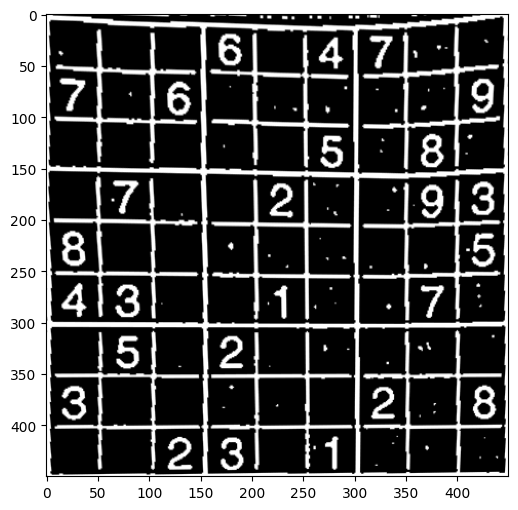

In [14]:
plt.figure(figsize=(8, 6))
plt.imshow(image_sudoku, cmap='gray')
plt.show()

## TESTING ANOTHER IMAGE

Loading the test image:

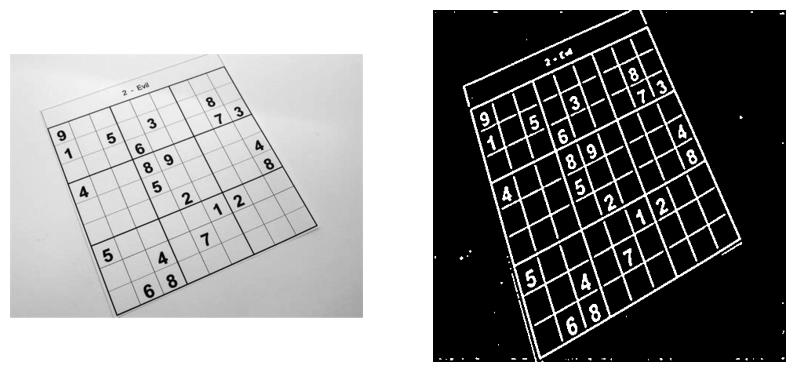

In [15]:
file_path  = '..\\examples\\sudoku_test_00.jpg'

image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
image_processed = preprocess(image)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_processed, cmap='gray')
plt.axis('off')

plt.show()

Getting the game grid in perspective:

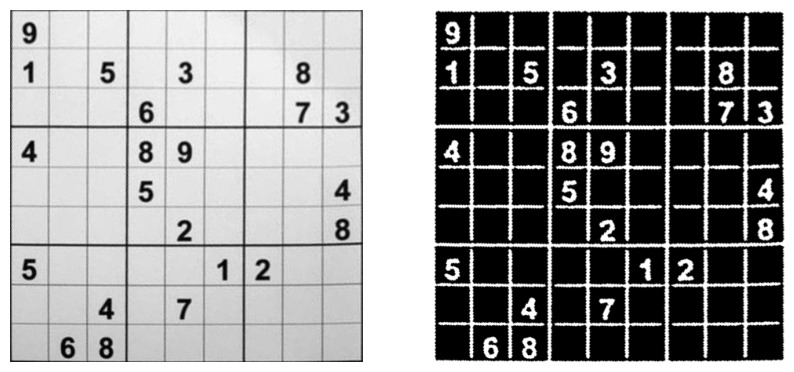

In [16]:
contours, _ = cv2.findContours(image_processed,
                               cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)
contour = biggest_contour(contours)

image_grid   = get_perspective(cv2.resize(image, shape), shape, contour)
image_sudoku = get_perspective(image_processed, shape, contour)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_grid, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_sudoku, cmap='gray')
plt.axis('off')

plt.show()

Getting the digits present in the game:

In [17]:
cells = split_cells(image_sudoku)

grid = np.zeros(81, 'uint8')
for idx, cell in enumerate(cells):
    if np.sum(cell) < 135000:
        continue

    cell = get_number(cell[5:-5, 5:-5])
    cell = cv2.resize(cell, shape_cell)
    cell = cell / 255.

    cell = np.expand_dims(cell, axis=[0, -1])
    pred = model.predict(cell, verbose=0).squeeze()

    label = np.argmax(pred)
    if pred[label] >= 0.5:
        grid[idx] = label

grid = grid.reshape(9, 9)
grid

array([[9, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 5, 0, 3, 0, 0, 8, 0],
       [0, 0, 0, 6, 0, 0, 0, 7, 3],
       [4, 0, 0, 8, 9, 0, 0, 0, 0],
       [0, 0, 0, 5, 0, 0, 0, 0, 4],
       [0, 0, 0, 0, 2, 0, 0, 0, 8],
       [5, 0, 0, 0, 0, 1, 2, 0, 0],
       [0, 0, 4, 0, 7, 0, 0, 0, 0],
       [0, 6, 8, 0, 0, 0, 0, 0, 0]], dtype=uint8)

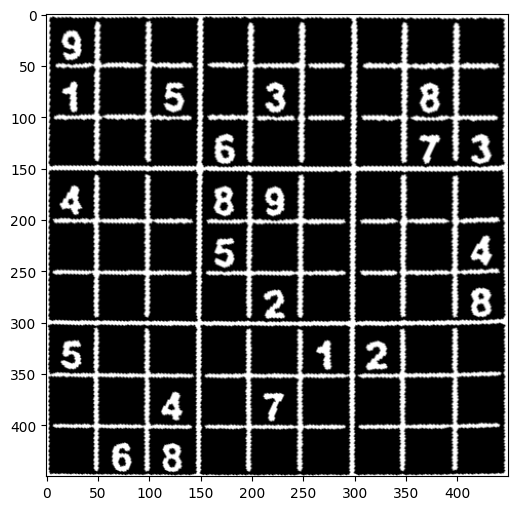

In [18]:
plt.figure(figsize=(8, 6))
plt.imshow(image_sudoku, cmap='gray')
plt.show()